## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from utils import dfm
from utils.abc import ABCSampler
# import astroabc
from utils import price_rogers_2014_binned
from tqdm.notebook import tqdm
from scipy.stats import gamma

%load_ext autoreload
%autoreload 2

My ABC setup requires

- a prior occurrence estimate.
- a candidate generator for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

I'm not 100% sure how any of these work.

In [2]:
kois = dfm.get_kois()
stellar = dfm.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
kois = kois[np.isfinite(kois["koi_prad"])]

[192950   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

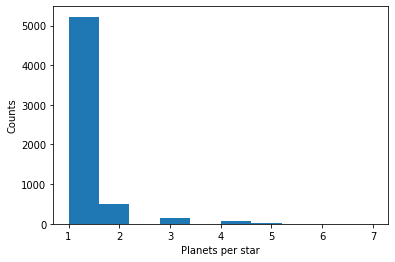

In [3]:
#starcounts = np.concatenate((np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten(), np.zeros((len(stellar[~stellar["kepid"].isin(kois["kepid"])]),))))
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
bincounts = np.bincount(solarsyssizes)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(solarsyssizes)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [4]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
koi_radii = kois["koi_prad"]
koi_periods = kois["koi_period"]

In [5]:
lam = np.mean(solarsyssizes)
# lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10) 
print([sum(planet_numbers == i) for i in range(max(planet_numbers))])

[61131, 71888, 42518, 16962, 4983, 1172, 220, 36]


(array([6.1131e+04, 7.1888e+04, 4.2518e+04, 1.6962e+04, 0.0000e+00,
        4.9830e+03, 1.1720e+03, 2.2000e+02, 3.6000e+01, 7.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

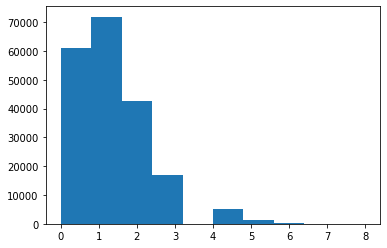

In [6]:
plt.hist(planet_numbers)

In [7]:
period = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period), np.log(rp)
period_rng = (min(period), max(period))
rp_rng = (min(rp), max(rp))

f = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]
f /= np.sum(f)

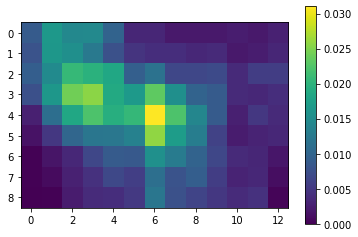

In [8]:
plt.imshow(f) # I guess that's sorta like an H-R diagram?
plt.colorbar()

In [9]:
bucket = np.random.choice(f.size, p=f.flatten())
i, j = bucket // f.shape[1], bucket % f.shape[1]
synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
ecc = stats.rayleigh(scale=0.03).rvs()
cosincl = np.random.uniform(-1, 1)
print("Generated planet with period {0} days, radius {1} Earth radii, eccentricity {2}, cos of orbital inclination {3}.".format(np.round(synth_p, 3), np.round(synth_r, 3), np.round(ecc, 3), np.round(cosincl, 3)))

Generated planet with period 0.618 days, radius 0.995 Earth radii, eccentricity 0.02, cos of orbital inclination 0.689.


In [154]:
cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

In [150]:
def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity
    """
    # do I not want a cos(i) in here?
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def pcomp(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

def pcomp_vectors(stars, periods, rp, eccs):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    
    mstars = np.array(stars['mass'])
    rstars = np.array(stars['radius'])
    cdpp = np.array(stars[cdpp_cols], dtype=float)
    dataspan = np.array(stars['dataspan'])
    dutycycle = np.array(stars['dutycycle'])
    mesthres_cols_stars = np.array(stars[mesthres_cols], dtype=float)
    
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    # sigma = np.apply_along_axis(np.interp, 0, tau, cdpp_vals, cdpp)
    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    # Compute the radius ratio and estimate the S/N.
    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    
    M = dataspan / periods
    f = dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) & (M >= 2.0)
    pwins = pw * msk
    
    pgeom = 1. / (aor * (1 - eccs*eccs)) * (aor > 1.0)
    
    return pdets * pwins * pgeom

In [151]:
test_star = stellar[stellar.kepid == kois.kepid[0]]
test_planet = kois[kois.kepid == kois.kepid[0]]

In [152]:
pcomp_vectors(test_star, test_planet['koi_period'], test_planet['koi_prad'], test_planet['koi_eccen'])

0    0.126051
dtype: float64

In [153]:
test_period = test_planet['koi_period'][0]
test_radius = test_planet['koi_prad'][0]
test_eccen = 0
pcomp(test_star.iloc[0], test_period, test_radius, test_eccen)

0.12605107055151948

In [ ]:
combined = pd.merge(kois, stellar, on='kepid')
plt.hist(pcomp(combined.iloc[0], combined['koi_period'], combined['koi_prad'], combined['koi_eccen']))

In [44]:
t0_range = (min(combined['koi_time0']), max(combined['koi_time0']))
bad_kepids = []

def generate_planets(f, star, num_planets=1):
    '''
    Takes in the occurrence rate matrix f and generates `num_planets' planets, 
    represented as a matrix of state (row) vectors.
    
    Each row has: period in days; radius in Earth radii; eccentricity; cosine of inclination; impact parameter;
    time of first transit in BJD; fractional transit depth; transit duration in days; is_detected (bool).
    '''
    params_size = 9 # [period, radius, ecc, cosincl, impact param b, t0, transit depth d, transit duration D, is_detected]
    planets = np.empty(shape=(num_planets, params_size))
    bucket = np.random.choice(f.size, p=f.flatten())
    k = 0
    fails = 0
    while k < num_planets:
        i, j = bucket // f.shape[1], bucket % f.shape[1]
        synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
        synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
        ecc = stats.rayleigh(scale=0.03).rvs()
        cosincl = np.random.uniform(0, 1) 
        r = synth_r / star.radius * 0.009158 # conversion from R_earth to R_sun
        b = np.random.uniform(0, 1) # Hsu 2018 ignores the possibility of b > 1
        t0 = np.random.uniform()
        d = r ** 2
        aor = get_a(synth_p, star.mass) / star.radius
        arcsin_arg = np.sqrt((1 + r) ** 2 - b ** 2) / aor
        if arcsin_arg > 1:
            fails += 1
            #print(r, b)
        D = (synth_p / np.pi) * np.arcsin(arcsin_arg)
        tau0 = synth_p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
        T = 2 * tau0 * np.sqrt(1 - b ** 2)
        tau = 2 * tau0 * r / np.sqrt(1 - b ** 2)
        f0 = 1
        texp = 1765.5 / 60 / 60 / 24 # s to days
        gamma = 1 / (6.5 / 60 / 60 / 24) # inverse s to inverse days
        sigma = 1 # 'model uncertainty'

        price_uncertainty_params = [d, T, tau, f0, texp, synth_p, gamma, sigma]
        var_d = abs(price_rogers_2014_binned.prVarDelta(*price_uncertainty_params)) # abs is stopgap
        var_D = 2 * abs(price_rogers_2014_binned.prVarTau(*price_uncertainty_params)) + abs(
            price_rogers_2014_binned.prVarTc(*price_uncertainty_params))
        var_b = abs(price_rogers_2014_binned.prVarBsq(*price_uncertainty_params))
        
        d += np.random.normal(0, np.sqrt(var_d))
        # D += np.random.normal(0, np.sqrt(var_D))
        # b += np.random.normal(0, np.sqrt(var_b))
        if all([b > 0, d > 0, D > 0, arcsin_arg <= 1]):
            detection = 1 # pcomp(star, synth_p, synth_r, ecc)
            planets[k] = np.array([synth_p, synth_r, ecc, cosincl, b, t0, d, D, bool(np.random.binomial(1, detection))])
            k += 1
            fails = 0
        else:
            fails += 1
        if fails > 5:
            bad_kepids.append(star.kepid)
            return np.empty((0, params_size))
        
    return planets

In [36]:
planet_catalog = np.empty((0, 9))
num_stars = len(stellar)
nums_planets = np.minimum(stats.poisson(lam).rvs((num_stars,)), 10)
stellar_sample = [row for row in stellar.sample(n=num_stars).iterrows()]

In [37]:
for i, (j, star) in enumerate(tqdm(stellar_sample)): 
    num_planets = nums_planets[i]
    new_planets = generate_planets(f, star, num_planets)

/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arcsin


In [38]:
len(set(bad_kepids) & set(kois.kepid))

178

In [42]:
len(bad_kepids)
np.save('./bad_kepids.npy', np.array(bad_kepids))

In [45]:
for i, (j, star) in enumerate(tqdm(stellar_sample)):
    if star.kepid not in bad_kepids:
        planet_catalog = np.vstack((planet_catalog, generate_planets(f, star, num_planets)))
        
np.save('./planet_catalog.npy', np.array(planet_catalog))

/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in arcsin


(array([142758.,  18333.,   8315.,   4977.,   3812.,   2807.,   2389.,
          2102.,   1896.,   1632.]),
 array([  0.50002554,  32.44655417,  64.3930828 ,  96.33961143,
        128.28614006, 160.23266869, 192.17919732, 224.12572595,
        256.07225458, 288.01878322, 319.96531185]),
 <a list of 10 Patch objects>)

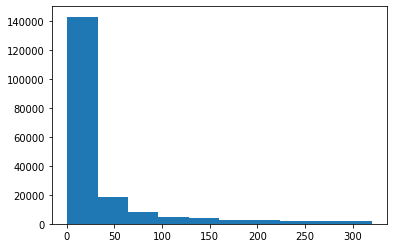

In [48]:
plt.hist(planet_catalog[:,0])

In [49]:
len(planet_catalog)

189021

In [16]:
i = 1
p = combined['koi_period'][i]
r = combined['koi_prad'][i]
rstar = combined['radius'][i]
ror = r / rstar * 0.009158
d = ror ** 2
b = combined['koi_impact'][i]
cosincl = np.cos(combined['koi_incl'][i] * np.pi / 180)
ecc = stats.rayleigh(scale=0.03).rvs() * 0
aor = get_a(p, combined['mass'][i]) / rstar
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
D = (p / np.pi) * np.arcsin(np.sqrt((1 + p / rstar) ** 2 - b ** 2) / aor)
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
tau = 2 * tau0 * r / np.sqrt(1 - b ** 2)
f0 = 1
texp = 1765.5 / 60 / 60 / 24 # s to days
gamma = 1 / (6.5 / 60 / 60 / 24) # inverse s to inverse days
sigma = 1 # 'model uncertainty'
price_uncertainty_params = [d, T, tau, f0, texp, p, gamma, sigma]
print(price_rogers_2014_binned.prVarDelta(*price_uncertainty_params))

-4.7346408106031984e-05
